# Orcid Adoption in Ireland
*by Neil Tynan @ATU*

![ORCiD](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.infodocket.com%2Fwp-content%2Fuploads%2F2020%2F11%2F1200px-ORCID_logo.svg_.png&f=1&nofb=1&ipt=deaeedbc3fcf61e94115e9f869a818bc3bc936d6d83f98f831c3669dd21c1e63&ipo=images)
###### *“Logo provided by ORCiD and used in line with the ORCID brand guidelines”*

The timeframe has been selected due to data availability (see READMe for more details).

## Import Libraries
---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import requests
from io import StringIO

## Active researchers in Ireland
---

First off, we need to determine the number of active researchers in Ireland over the course of the timeframe. The CSO provides annual data to the OECD on research activity in Ireland. So, we should be able to pull the data from their API.

In [3]:
# Load in OECD Data
oecdapi = "https://sdmx.oecd.org/public/rest/data/OECD.STI.STP,DSD_RDS_PERS@DF_PERS_FUNC,/.A.._T..._T.._T..PS_FTE?startPeriod=2001&format=csvfilewithlabels"
response = requests.get(oecdapi)
oecd_data = StringIO(response.text)
oecd = pd.read_csv(oecd_data)
oecd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STRUCTURE                 858 non-null    object 
 1   STRUCTURE_ID              858 non-null    object 
 2   STRUCTURE_NAME            858 non-null    object 
 3   ACTION                    858 non-null    object 
 4   REF_AREA                  858 non-null    object 
 5   Reference area            858 non-null    object 
 6   FREQ                      858 non-null    object 
 7   Frequency of observation  858 non-null    object 
 8   MEASURE                   858 non-null    object 
 9   Measure                   858 non-null    object 
 10  SECT_PERF                 858 non-null    object 
 11  Sector of performance     858 non-null    object 
 12  FORD                      858 non-null    object 
 13  Field of R&D              858 non-null    object 
 14  ACTIVITY  

In [4]:
# Seperate out Irish data
irl = oecd[oecd['Reference area'] == 'Ireland']
irl2022 = irl.loc[irl['TIME_PERIOD'].isin([2022])]

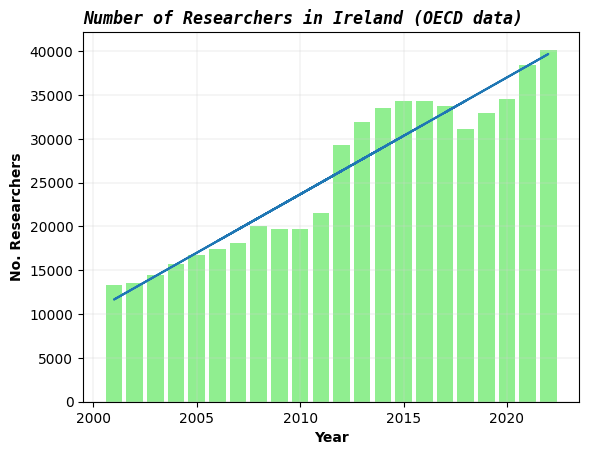

Number of Irish Researchers in 2022: 40174.0


In [5]:
# Generate Bar Chart
plt.bar(irl['TIME_PERIOD'], irl['OBS_VALUE'], color='lightgreen')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("No. Researchers", fontweight='bold')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Number of Researchers in Ireland (OECD data)', fontweight='bold', style='italic', family='monospace', loc = 'left')

# Calculate the Trendline
z = np.polyfit(irl['TIME_PERIOD'], irl['OBS_VALUE'], 1)
p = np.poly1d(z)
plt.plot(irl['TIME_PERIOD'], p(irl['TIME_PERIOD']))

plt.show()
print("Number of Irish Researchers in 2022:", irl2022["OBS_VALUE"].values[0])

As per the trendline, we can see a fairly steady increase in active researchers in Ireland throughout the surved period. We now have the baseline data we need to work out the answer to our core question. The next step will be trying to establish the ORCiD approval rate on the SFI side of things.

## ORCID adoption amoung SFI Grant Holders
---

Now that we have the data for Ireland, we will need to get the data for SFI next. Science Foundation Ireland published an annual data file every year on data.gov.ie which list details of the awards that were made that year. This includes a list of the year's awardees and, for those willing to publish them, their associated ORCiDs.

In [6]:
# Read in the Science Foundation Ireland Grant Committment List
url = "https://www.sfi.ie/about-us/governance/open-data/Open-Data-2023-11-30.csv"
sfi = pd.read_csv(url)
sfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Proposal ID                  6938 non-null   object
 1   Programme Name               6938 non-null   object
 2   Sub-Programme                2307 non-null   object
 3   Supplement                   1257 non-null   object
 4   Lead Applicant               6938 non-null   object
 5   ORCID                        5169 non-null   object
 6   Research Body                6938 non-null   object
 7   Research Body ROR ID         6637 non-null   object
 8   Funder Name                  6938 non-null   object
 9   Crossref Funder Registry ID  6938 non-null   object
 10  Proposal Title               6936 non-null   object
 11  Start Date                   6938 non-null   object
 12  End Date                     6938 non-null   object
 13   Current Total Commitment    6938

In [7]:
# Convert dates to datetime
sfi['Start Date'] = pd.to_datetime(sfi['Start Date'])
sfi['End Date'] = pd.to_datetime(sfi['End Date'])
sfi[' Current Total Commitment '] = sfi[' Current Total Commitment '].astype(str)
sfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Proposal ID                  6938 non-null   object        
 1   Programme Name               6938 non-null   object        
 2   Sub-Programme                2307 non-null   object        
 3   Supplement                   1257 non-null   object        
 4   Lead Applicant               6938 non-null   object        
 5   ORCID                        5169 non-null   object        
 6   Research Body                6938 non-null   object        
 7   Research Body ROR ID         6637 non-null   object        
 8   Funder Name                  6938 non-null   object        
 9   Crossref Funder Registry ID  6938 non-null   object        
 10  Proposal Title               6936 non-null   object        
 11  Start Date                   6938 non-null 

In [8]:
# Pull out the ORCiD column
OID = sfi['ORCID']
OID.head(2)

0    https://orcid.org/0000-0002-8539-3143
1    https://orcid.org/0000-0003-3646-8222
Name: ORCID, dtype: object

In [9]:
# Seperate out those awardees with ORCiDs and those without
OIN = OID.isna()
OINS = OIN.sum()
print("Number of SFI Reseachers without an ORCiD:", OINS)

ONN = OID.notnull()
ONNS = ONN.sum()
print("Number of SFI Reseachers with an ORCiD:", ONNS)


Number of SFI Reseachers without an ORCiD: 1769
Number of SFI Reseachers with an ORCiD: 5169


Text(0.5, 1.0, 'Percentage of Historical SFI Grant Holders with an ORCiD')

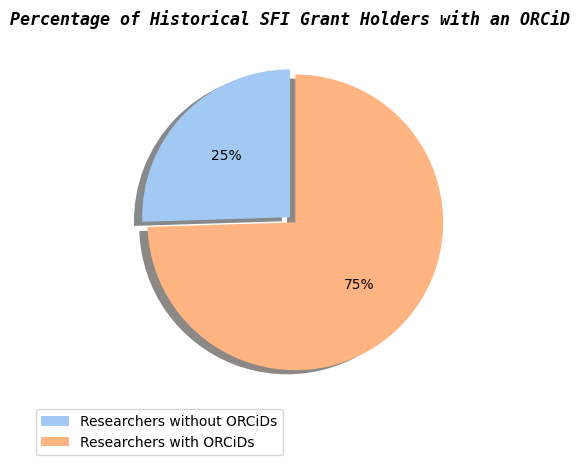

In [10]:
# Define data
data = [OINS, ONNS]
labels = ['Researchers without ORCiDs', 'Researchers with ORCiDs']
explode = (0, 0.05)

# Define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

# Create pie chart
plt.pie(data, explode=explode, colors = colors, autopct='%.0f%%', shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.legend(labels, loc='best', bbox_to_anchor=(0, 0., 0.5, 0))
plt.title('Percentage of Historical SFI Grant Holders with an ORCiD', fontweight='bold', style='italic', family='monospace', loc = 'center') 


This give us the overall breakdown of the SFI grant data. However, it does not give us not give us the breakdown of the data by year that we need in order to contrast it with the overall data for Ireland. To get that, we will need to convert the data ranges into datetime and look at the data on an annual basis.

In [11]:
# Grouping the data into date blocks for analysis
SD = sfi['Start Date']
ONNY = ONN.groupby(SD.dt.year).sum()
OINY = OIN.groupby(SD.dt.year).sum()

# Adding in date ranges, as there is only partial data for 2024
dateFrom = "2001"
dateTo = "2022"

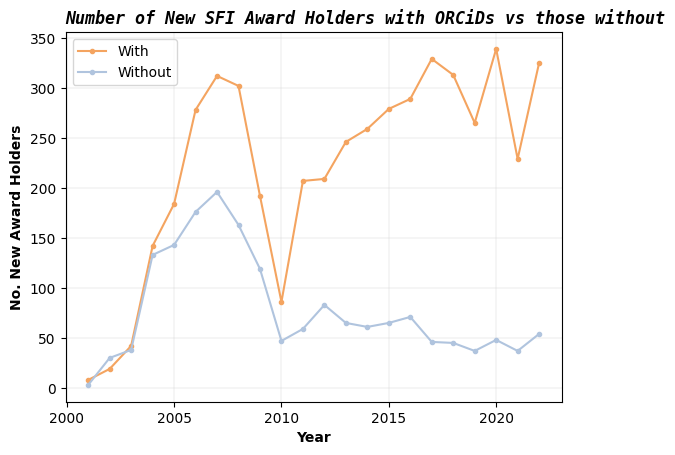

Number of New Award Holders with ORCiDs in 2022: 325


In [12]:
# Charting the SFI ORCiD data
plt1, = plt.plot(ONNY.loc[dateFrom:dateTo], marker='.', color='sandybrown')
plt2, = plt.plot(OINY.loc[dateFrom:dateTo], marker='.', color='lightsteelblue')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("No. New Award Holders", fontweight='bold')
plt.legend([plt1,plt2],["With", "Without"], loc = 'upper left')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Number of New SFI Award Holders with ORCiDs vs those without', fontweight='bold', style='italic', family='monospace', loc = 'left')
plt.show()

#Get the result for 2022
ONNY.loc[2022]
print("Number of New Award Holders with ORCiDs in 2022:", ONNY.loc[2022])

That gives us the annual data that we want. The next step is to look at these result for both of these categories as a percentage of the overall total number of new award holders. 

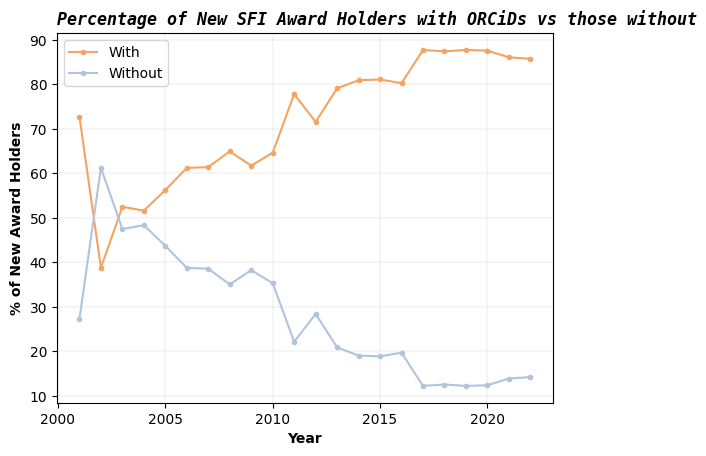

Percentage of New Award Holders with ORCiDs in 2022: 85.75197889182058


In [13]:
# Chart the SFI ORCiD data as a percentage
ONNT = ONNY.loc[dateFrom:dateTo] + OINY.loc[dateFrom:dateTo]
ONNYP = ONNY.loc[dateFrom:dateTo] / ONNT * 100
OINYP = OINY.loc[dateFrom:dateTo] / ONNT * 100

# Generate new chart
plt1, = plt.plot(ONNYP, marker='.', color='sandybrown')
plt2, = plt.plot(OINYP, marker='.', color='lightsteelblue')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("% of New Award Holders", fontweight='bold')
plt.legend([plt1, plt2], ["With", "Without"], loc='upper left')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Percentage of New SFI Award Holders with ORCiDs vs those without', fontweight='bold', style='italic', family='monospace', loc='left')
plt.show()

#Get the result for 2022
ONNYP.loc[2022]
print("Percentage of New Award Holders with ORCiDs in 2022:", ONNYP.loc[2022])

Looking at things from a percentage perspective give us a pretty good idea of how ORCiD approval has progressed over time amoung SFI's researchers. Some initial variance has given way to a clear trend: the number of awardees with an ORCiD has increased markedly over time, leading to a concurrent sharp drop in the numer of awardees without an ORCiD.

Now that we have these percentages, we should also have the data that we need in order to make an estimate of what the national figures might look like.

## Working out estimate Irish figures using the SFI data
---

To work out the national estimate, the first thing we need to do is put together a new dataframe with the relevant OECD and SFI data. We can then use that new dataframe to work out an estimate for what the national approval level might look like.

In [14]:
# Generate new dataframe to merge relevant OECD and SFI data
df = pd.DataFrame(irl.loc[:, ["OBS_VALUE","TIME_PERIOD"]])
dff = df.set_index('TIME_PERIOD')
per = pd.DataFrame(ONNYP/100)
per.rename(columns={'ORCID': 'ORCPer'}, inplace=True)
per2 = pd.DataFrame(OINYP/100)
per2.rename(columns={'ORCID': 'NoORCPer'}, inplace=True)
hold = pd.merge(per, dff, left_index=True, right_index=True)
data = pd.merge(hold, per2, left_index=True, right_index=True)

# Create new columns based off the overall IRL researcher numbers and the percentage of SFI awardees with ORCiDs
data['ORCiD'] = data.OBS_VALUE * data["ORCPer"]
data['NoORCiD'] = data.OBS_VALUE * data["NoORCPer"]

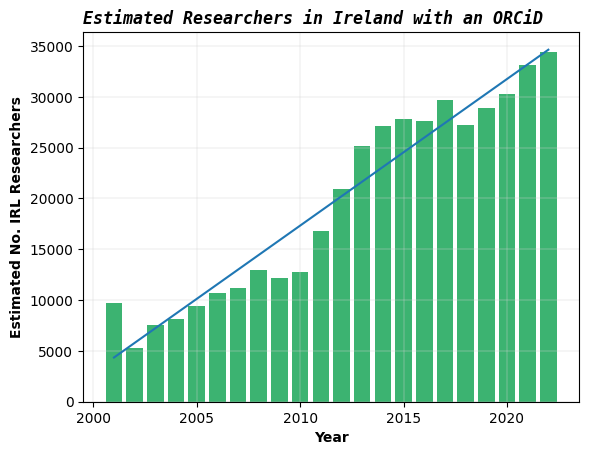

In [15]:
# Generate Bar Chart for estimated IRL Researchers with ORCiDs
plt.bar(data.index, data['ORCiD'], color='mediumseagreen')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Estimated No. IRL Researchers", fontweight='bold')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Estimated Researchers in Ireland with an ORCiD', fontweight='bold', style='italic', family='monospace', loc = 'left')

# Calculate the Trendline
z = np.polyfit(data.index, data['ORCiD'], 1)
p = np.poly1d(z)
plt.plot(data.index, p(data.index))

plt.show()

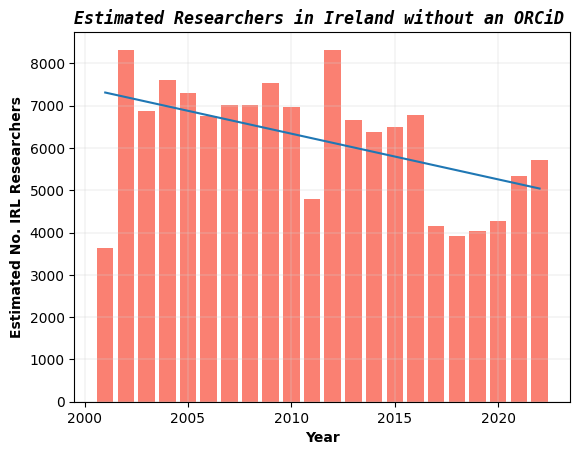

In [16]:
# Generate Bar Chart for estimated IRL Researchers without an ORCiD
plt.bar(data.index, data['NoORCiD'], color='salmon')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Estimated No. IRL Researchers", fontweight='bold')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Estimated Researchers in Ireland without an ORCiD', fontweight='bold', style='italic', family='monospace', loc = 'left')

# Calculate the Trendline
z = np.polyfit(data.index, data['NoORCiD'], 1)
p = np.poly1d(z)
plt.plot(data.index, p(data.index))

plt.show()

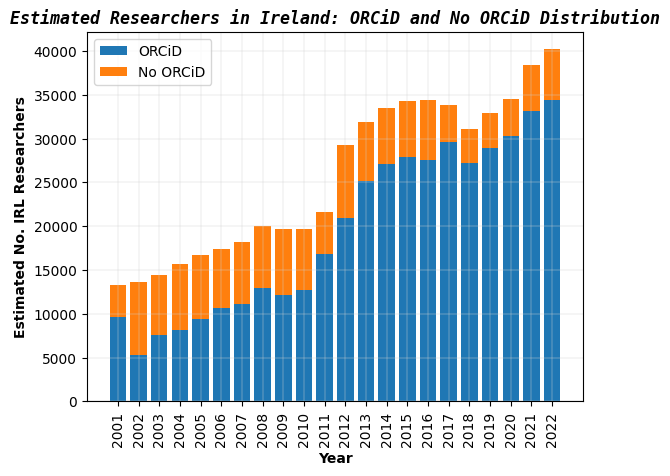

In [17]:
# Generate stacked bar chart for easy comparison of the overall numbers in both categories
fig, ax = plt.subplots()
ax.bar(data.index, data["ORCiD"], label='ORCiD')
ax.bar(data.index, data["NoORCiD"], bottom=data["ORCiD"], label='No ORCiD')
ax.set_title("Estimated Researchers in Ireland: ORCiD and No ORCiD Distribution", fontweight='bold', style='italic', family='monospace')
ax.set_xlabel("Year", fontweight='bold')
ax.set_ylabel("Estimated No. IRL Researchers", fontweight='bold')
ax.grid(color='lightgrey', linestyle='-', linewidth=0.3)
ax.set_xticks(data.index)
ax.set_xticklabels(data.index, rotation=90)  
ax.legend()

# END